# Imports

In [1]:
import numpy as np
import json
import cv2 as cv
import matplotlib.pyplot as plt

import tensorflow as tf

# Data preprocessing

In [2]:
IMG_DIR = "Images"
JSON = "StanfordExtra_V12/StanfordExtra_v12.json"
KEYPOINT_DEF = (
    "https://github.com/benjiebob/StanfordExtra/raw/master/keypoint_definitions.csv"
)

with open(JSON) as infile:
    json_data = json.load(infile)

json_dict = {'Images/'+i["img_path"]: i for i in json_data}

In [3]:
json_dict

{'Images/n02085782-Japanese_spaniel/n02085782_2886.jpg': {'img_path': 'n02085782-Japanese_spaniel/n02085782_2886.jpg',
  'img_width': 350,
  'img_height': 272,
  'img_bbox': [205, 20, 116, 201],
  'is_multiple_dogs': False,
  'joints': [[108.66666666666667, 252.0, 1],
   [147.66666666666666, 229.0, 1],
   [163.5, 208.5, 1],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [54.0, 244.0, 1],
   [77.33333333333333, 225.33333333333334, 1],
   [79.0, 196.5, 1],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [150.66666666666666, 86.66666666666667, 1],
   [88.66666666666667, 73.0, 1],
   [116.0, 106.33333333333333, 1],
   [109.0, 123.33333333333333, 1],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0]],
  'seg': 'Yi71c01S74jHNU75gHMX75eHM[74cHM\\76`HL4HQ7k0lHXOT7R1O2N010O010jLiNROW1m0lNROT1m0oNPOQ1P1QOoNn0R1ROnNn0oMkNQ2:Nl0oMlNQ2:0j0nMnNP291j0mMoNR280j0kMPOLEg1c0`0i0lMCb1Db0i0jMGa1Ae0h0iMI`1_Og0j0fMK`1\\Oj0i0eMN^1ZOl0i0dM1]1WOm0k0cM2]1TO

In [4]:
image_path = 'n02085782-Japanese_spaniel/n02085782_2886.jpg'

def draw_key_points(path: str):
    '''
    Draw the keypoints of an image
    '''
    # path = path.decode('utf-8').replace('\\', '/')
    img = cv.imread(str(path))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB) 

    kp = json_dict[path]['joints']

    for p in kp:
        x,y = int(p[0]), int(p[1])
        cv.circle(img, (x,y), 2, (0,0,255), 2)

    plt.imshow(img)

    return img, kp

In [5]:
from sklearn.model_selection import train_test_split

imgs = [i for i in json_dict]

X_train, X_test = train_test_split(imgs, test_size=.1)
X_test, X_val = train_test_split(X_test, test_size=.5)

In [6]:
print(len(X_train))
print(len(X_test))
print(len(X_val))

11284
627
627


### some checks on the data

In [7]:
#ensure all the keypoints has the same length
s = set()
for i in json_dict:
    s.add(len(json_dict[i]['joints']))

s

{24}

In [8]:
#return last value of all kp
s = set()
for i in json_dict:
    for j in range(24):
        s.add(json_dict[i]['joints'][j][2])

s

{0, 1}

this mean that for each image we should predict 24 joint

### utility functions/classes

In [9]:
from dataclasses import dataclass

@dataclass
class Args:
    image_size: int = 224
    num_augmentations_per_image: int = 1
    batch_size: int = 16
    n_classes: int = 48
    augmantation_factor: int = 3
    sigma: float = 2.0

args = Args()

In [10]:
def verify_augmantation(img, kp, proba):
    """
    plot the given key points on the given img
    """
    # img, kp = x[0].numpy(), x[1].numpy()
    joints = np.reshape(kp, (24, 2))
    # plt.imshow(img)
    j = 0
    for kp in joints:
        if proba[j]:
            x,y = int(kp[0]), int(kp[1])
            cv.circle(img, (x,y), 2, (0,0,255), 2)
        j += 2
    plt.imshow(img)


In [82]:
import albumentations  as A

def train_augmantation(img, kp, proba):

    transform = A.Compose([
        A.Resize(width=args.image_size, height=args.image_size, p=1),
        A.VerticalFlip(p=.3),
        A.Rotate(p=0.2),
        A.OneOf([
                A.HueSaturationValue(p=0.5), 
                A.RGBShift(p=0.7)
            ], p=.6),
        A.RandomBrightnessContrast(p=0.4),
    ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

    transformed = transform(image=img, keypoints=kp)
    kp = []
    for p in transformed['keypoints']:
        if np.isnan(p[0]) or np.isnan(p[1]):
            kp.append(0)
            kp.append(0)
        else:
            kp.append(p[0])
            kp.append(p[1])
    
    # verify_augmantation(transformed['image'], transformed['keypoints'], proba)

    return transformed['image'], {'points':kp, 'probabilities': proba}

def test_val_augmantation(img, kp, proba):

    transform = A.Compose([
        A.Resize(width=args.image_size, height=args.image_size, p=1)
    ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

    transformed = transform(image=img, keypoints=kp)
    kp = []
    for p in transformed['keypoints']:
        if np.isnan(p[0]) or np.isnan(p[1]):
            kp.append(0)
            kp.append(0)
        else:
            kp.append(p[0])
            kp.append(p[1])
    
    # verify_augmantation(transformed['image'], transformed['keypoints'], proba)

    return transformed['image'], {'points':kp, 'probabilities': proba}

In [83]:
def preprocess(path, train: bool=True):
    img = cv.imread(str(path))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    kp = []
    proba =  []
    for p in json_dict[path]['joints']:
        kp.append([p[0], p[1]])
        proba.append(p[2])
        proba.append(p[2])

    if train:
        return train_augmantation(img, kp, proba)
    
    return test_val_augmantation(img, kp, proba)

In [95]:
import os

def train_generator():
    for p in X_train:
        yield preprocess(p)

output_shapes = (tf.TensorShape([None, None, None]), {'points': tf.TensorShape([None,]), 'probabilities': tf.TensorShape([None,])})
output_types = (tf.float32, {'points': tf.float32, 'probabilities': tf.float32})

train_ds = tf.data.Dataset.from_generator(train_generator, output_types=output_types, output_shapes=output_shapes)\
                          .batch(args.batch_size).repeat()

def test_generator():
    for p in X_test:
        yield preprocess(p, train=False)


test_ds = tf.data.Dataset.from_generator(test_generator, output_types=output_types, output_shapes=output_shapes)\
                          .batch(args.batch_size)

def val_generator():
    for p in X_val:
        yield preprocess(p, train=False)

val_ds = tf.data.Dataset.from_generator(val_generator, output_types=output_types, output_shapes=output_shapes)\
                          .batch(args.batch_size)


In [85]:
iterator = iter(val_ds)

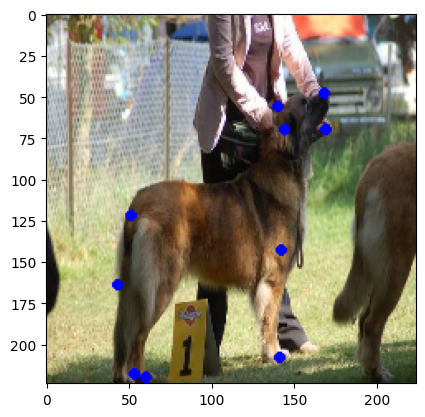

In [92]:
img, heatmap = next(iterator)

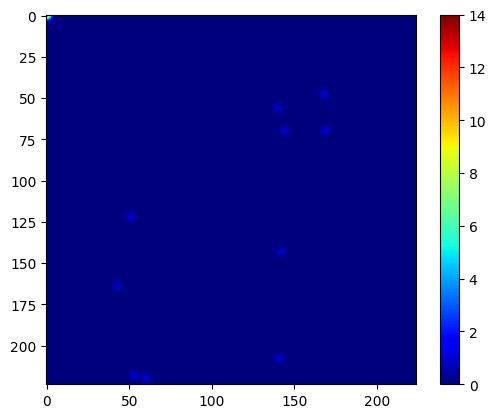

In [93]:
plt.imshow(np.sum(heatmap.numpy().squeeze(), axis=-1), cmap='jet')
plt.colorbar()
plt.show()

In [333]:
from keras.layers import Input, Flatten, Dense, Flatten, Add
from keras import Model
from keras.applications.mobilenet_v3 import MobileNetV3Small

sub_model = MobileNetV3Small(include_top=False, include_preprocessing=True, input_shape=(224, 224, 3))

inp = Input(shape=(224,224,3))
x = sub_model(inp)
x = Flatten()(x)
# x = Dense(256, activation='relu')(x)
x = Dense(args.n_classes, activation='relu')(x)
probas = Dense(args.n_classes, activation='sigmoid', name='probabilities')(x)
x = Add()([x, probas])
points = Dense(args.n_classes, activation='relu', name='points')(x)


model = Model(inp, [probas, points])
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), 
              loss={'probabilities': 'binary_crossentropy', 'points': 'mse'},
              metrics={'probabilities': 'acc'})
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 MobilenetV3small (Functional)  (None, 7, 7, 576)    939120      ['input_38[0][0]']               
                                                                                                  
 flatten_11 (Flatten)           (None, 28224)        0           ['MobilenetV3small[0][0]']       
                                                                                                  
 dense_28 (Dense)               (None, 48)           1354800     ['flatten_11[0][0]']      

In [334]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience=1, monitor='points_loss')

In [335]:
steps  = (len(X_train)//args.batch_size) * args.augmantation_factor

model.fit(train_ds, epochs=6, validation_data=val_ds, steps_per_epoch=steps, callbacks=[es])

Epoch 1/6


2115/2115 [==============================] - 179s 83ms/step - loss: 3816.7178 - probabilities_loss: 5.4674 - points_loss: 3811.2476 - probabilities_acc: 0.4774 - val_loss: 2750.5542 - val_probabilities_loss: 4.1195 - val_points_loss: 2746.4348 - val_probabilities_acc: 0.1308
Epoch 2/6
2115/2115 [==============================] - 175s 83ms/step - loss: 3030.2500 - probabilities_loss: 3.9182 - points_loss: 3026.3276 - probabilities_acc: 0.4714 - val_loss: 2561.7542 - val_probabilities_loss: 3.5834 - val_points_loss: 2558.1707 - val_probabilities_acc: 0.5630
Epoch 3/6
2115/2115 [==============================] - 190s 90ms/step - loss: 2820.1409 - probabilities_loss: 3.4824 - points_loss: 2816.6584 - probabilities_acc: 0.4656 - val_loss: 2661.5691 - val_probabilities_loss: 3.6538 - val_points_loss: 2657.9153 - val_probabilities_acc: 0.5534
Epoch 4/6
2115/2115 [==============================] - 208s 98ms/step - loss: 2636.5242 - probabilities_loss: 3.2948 - points_loss: 2633.2302 - probabil

1/1 [==============================] - 0s 24ms/step


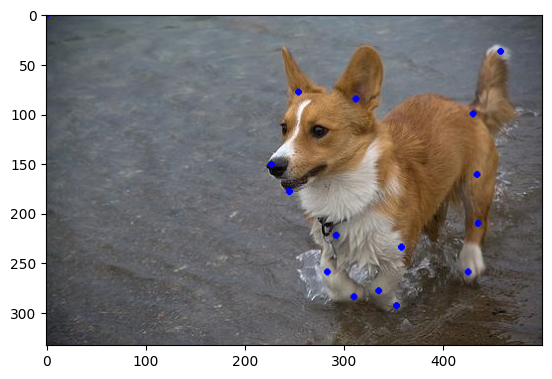

In [371]:
path = X_test[100]
draw_key_points(path);

img = cv.imread(path)
kp = json_dict[path]['joints']
# print(kp)
tf_img = tf.expand_dims(tf.image.resize(img, [args.image_size, args.image_size]), 0)
# preds = model.predict(tf_img) * args.image_size
# outs = np.reshape(preds, (24, 2))
# # print(outs)
proba, points = model.predict(tf_img)
points = np.reshape(points, (24, 2))
proba = np.round(proba).squeeze()

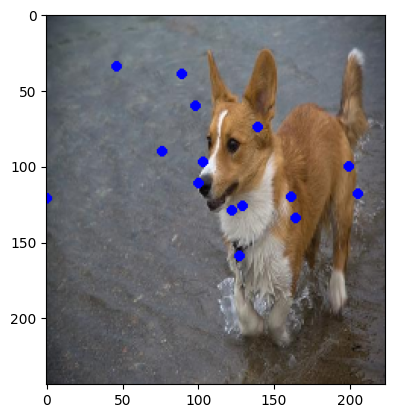

In [372]:
img = cv.resize(cv.imread(path), (224, 244))
img = cv.cvtColor(img, cv.COLOR_BGR2RGB) 
j = 0
for p in points:
    if proba[j]:
        x,y = int(p[0]), int(p[1])
        cv.circle(img, (x,y), 2, (0,0,255), 2)
    j += 2

plt.imshow(img)